### Import Library

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import sklearn
import numpy as np
from sklearn.linear_model import LinearRegression
from theano import shared
from sklearn.metrics import mean_absolute_error as mape
import arviz as az
%matplotlib inline
RANDOM_SEED=58

### Data processing

In [113]:
fred_df = pd.read_parquet('fred_df.parquet', engine='pyarrow')
credit_card_df = pd.read_parquet('credit_card_df.parquet', engine='pyarrow').sort_values(by='optimized_date')

fred_df_us_retail_advanced = fred_df[fred_df['type'] == 'us_retail_advanced'].reset_index()
fred_df_us_retail_advanced['date'] = fred_df_us_retail_advanced['date'].dt.to_period('M')
credit_card_df['optimized_date'] = pd.to_datetime(credit_card_df['optimized_date'])
credit_card_df_simple=credit_card_df[['optimized_date','state','panel_sales','yoy_trailing_four_week_sales']]
credit_card_df_simple=credit_card_df_simple.groupby(['optimized_date']).mean()    
credit_card_df_simple['optimized_date']=credit_card_df_simple.index
credit_card_df_simple['month_year'] = credit_card_df_simple['optimized_date'].dt.to_period('M')
credit_card_df_temp=credit_card_df_simple[['month_year','optimized_date','yoy_trailing_four_week_sales']]
credit_card_df_simple=credit_card_df_simple[['month_year','panel_sales']]
credit_card_df_simple=credit_card_df_simple.groupby(['month_year']).mean()
credit_card_df_temp=credit_card_df_temp.groupby(['month_year']).last()
credit_card_df_simple = credit_card_df_simple.join(credit_card_df_temp)
df_train = fred_df_us_retail_advanced.set_index('date').join(credit_card_df_simple)
df_train = pd.DataFrame.dropna(df_train).reset_index()

In [114]:
# standardize the date to unit scale; mean 0 and variance 1

df_train['y'] = df_train.value
df_train['Qtr'] = df_train.date.dt.quarter-1

drop_columns = ['index','type','value','optimized_date','date']
df_train = df_train.drop(drop_columns,axis=1)
df_train.iloc[:,:-1] = sklearn.preprocessing.scale(df_train.iloc[:,:-1])


### Train Test Split

In [115]:
test_start  = int(len(df_train) * 0.7)
train = df_train[:test_start]
test = df_train[test_start:]

train_X = train[['panel_sales','yoy_trailing_four_week_sales','Qtr']]

train_Y = train['y'].values

test_X = test[['panel_sales','yoy_trailing_four_week_sales','Qtr']]

test_Y = test['y'].values


Have Tried flat prior which yield the similar results so started with weakly informative priors instead

### Modelling with weakly infomative priors

In [116]:
# set shared predictor
predictor_1 = np.asarray(train_X['panel_sales'])
obs_data = train_Y

with pm.Model() as model_naive:
    std = pm.Exponential("std", 1.0)
    
    beta_0 = pm.Normal("beta_0", mu=0, sd=0.5)
    beta_1 = pm.Normal("beta_1", mu=0, sd=1)
    
    # As data is on unit scale.
    pred_1 = pm.Data("pred_1", predictor_1)
    
    mean = pm.Deterministic("mean", beta_0  + beta_1 * pred_1)

    obs = pm.Normal("obs", mu=mean, sd=std, observed=obs_data)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)



### Prior predictive checks

Text(0.5, 1.0, 'Prior predictive checks -- weakly infomative priors')

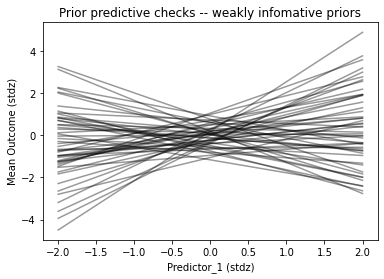

In [117]:
_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["beta_0"], prior_checks["beta_1"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor_1 (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- weakly infomative priors")

* Showing outcome stays in the realm of possibilities

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_1, beta_0, std]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.


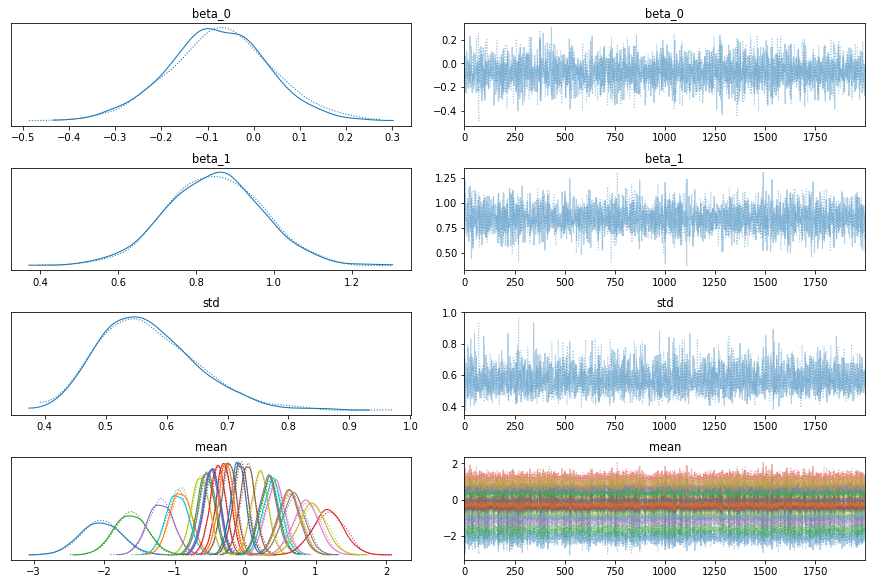

In [118]:
with model_naive:
    trace = pm.sample(2000,tune=1000,random_seed=RANDOM_SEED)
    pm.traceplot(trace)

### Posterior Predictive Checks

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


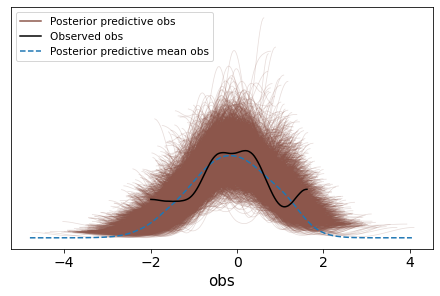

In [119]:
with model_naive:
       ppc = pm.sample_posterior_predictive(
        trace, var_names=["beta_0", "beta_1", "obs"], random_seed=RANDOM_SEED
      )
        
idata = az.from_pymc3(trace, posterior_predictive=ppc)
az.plot_ppc(idata);

* Here ppc contains 4000 generated data sets (containing 29 samples each).
* As seen, the model is not very good at retrodicting the data.

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


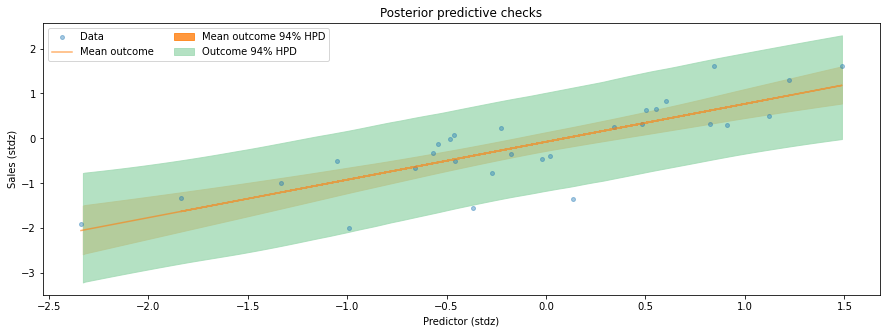

In [120]:
mu_pp = (ppc["beta_0"] + ppc["beta_1"] * predictor_1[:, None]).T

_, ax = plt.subplots(figsize=(15,5))

ax.plot(predictor_1, obs_data, "o", ms=4, alpha=0.4, label="Data")
ax.plot(predictor_1, mu_pp.mean(0), label="Mean outcome", alpha=0.6)
az.plot_hpd(
    predictor_1,
    mu_pp,
    ax=ax,
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
)
az.plot_hpd(
    predictor_1,
    ppc["obs"],
    ax=ax,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Outcome 94% HPD"},
)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Sales (stdz)")
ax.set_title("Posterior predictive checks")
ax.legend(ncol=2, fontsize=10);

* showing relationship between predictor and outcome
* uncertainty surrounding the outcome seems in line with the observed data

### Modelling - Add Regressor

In [121]:
predictor_1 = np.asarray(train_X['panel_sales'])        
predictor_2 = np.asarray(train_X['yoy_trailing_four_week_sales'])   

with pm.Model() as model_add_regressor:
    std = pm.HalfCauchy("sd", 2.0)
    
    betas = pm.Normal("betas", mu=0.0, sd=np.array([0.5, 1.0, 1.0]), shape=3)
    
    # set predictors as shared variable to change them for PPCs:
    pred_1 = pm.Data("pred_1", predictor_1)
    pred_2 = pm.Data("pred_2", predictor_2)
    
    mean = pm.Deterministic("mean", betas[0] + betas[1] * pred_1 + betas[2] * pred_2)
    
    obs = pm.Normal("obs", mu=mean, sd=std, observed=obs_data)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sd]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 12 seconds.


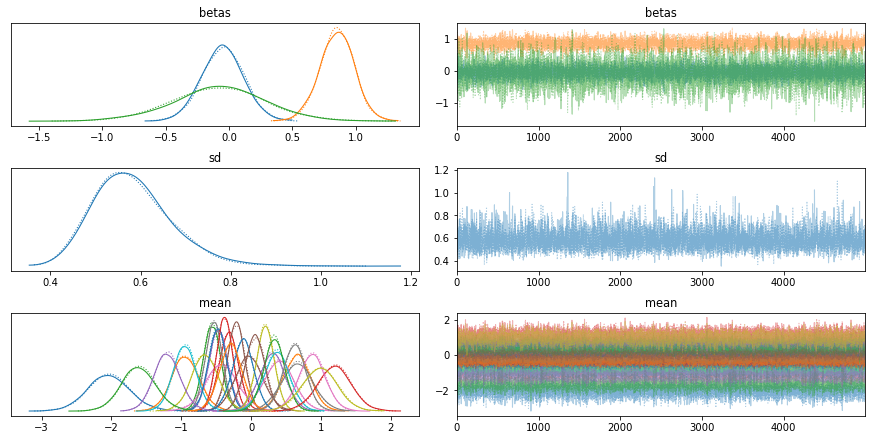

In [122]:
with model_add_regressor:
    trace_add_regressor = pm.sample(5000,tune=1000, cores=2)
    pm.traceplot(trace_add_regressor)

### Posterior Preditive Check

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


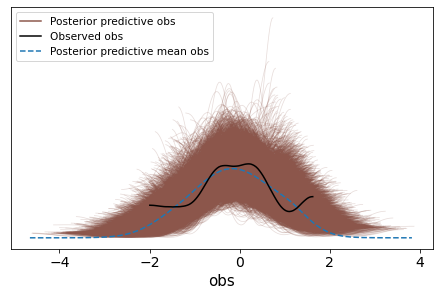

In [123]:
with model_add_regressor:
       ppc = pm.sample_posterior_predictive(
        trace_add_regressor, var_names=["betas", "obs"], random_seed=RANDOM_SEED
      )
        
idata = az.from_pymc3(trace_add_regressor, posterior_predictive=ppc)
az.plot_ppc(idata);

* Not much change in underlying shape of posterior distribution by adding a regressor.
* Might try another probability model for further improvement.
* However, by adding regressor does imporve our forcast on out of sample prediction in some aspects see below

### Out of sample forecast

In [124]:
predictors_1_out_of_sample = np.asarray(test_X['panel_sales'])
predictors_2_out_of_sample = np.asarray(test_X['yoy_trailing_four_week_sales'])
outcomes_out_of_sample = test['y'].values
with model_add_regressor:
    # update values of predictors:
    pm.set_data({"pred_1": predictors_1_out_of_sample})
    pm.set_data({"pred_2": predictors_2_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    pp_trace = pm.sample_posterior_predictive(trace_add_regressor,samples=2000)

/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


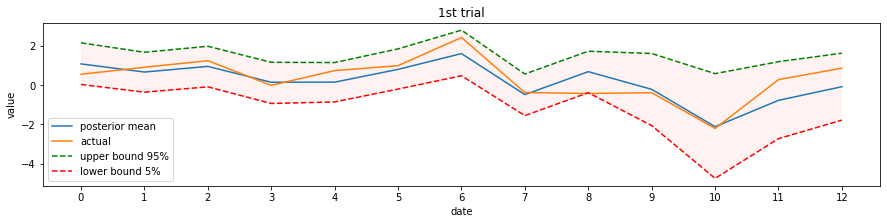

Mean Absolute Percetage Error: 0.48 %


In [125]:
obs_simulations = pp_trace['obs']
obs_simulations_reshape = obs_simulations.T
upper_bound = np.quantile(obs_simulations_reshape, 0.95, axis=1)
lower_bound = np.quantile(obs_simulations_reshape, 0.05, axis=1)
mean = pp_trace['obs'].mean(axis=0)

fig, ax = plt.subplots(figsize=(15,3))
ax.set_title ('1st trial')
ax.plot(mean,label='posterior mean')
ax.plot(test_Y,label='actual')
ax.plot(upper_bound,label='upper bound 95%',color='green',linestyle='--')
ax.plot(lower_bound,label='lower bound 5%',color='red',linestyle='--')

ax.set_xlabel('date')
ax.fill_between(np.arange(len(test)), lower_bound, upper_bound,facecolor='red', alpha=0.05)
ax.set_ylabel('value')
ax.set_xticks(np.arange(len(test)))
ax.legend()
plt.show()

print('Mean Absolute Percetage Error: {} %'.format(mape(test_Y,mean).round(2)))

* MAPE is lower with two regressors (0.48%) than with only one regressor (0.52%, shown in pipeline notebook)
* Unlike model with one regressor, all observed data falls in uncertainty bound with two regressors.

### Go Hierarchical 

* Indexed by quarters of the year as group because paramenters for the same quarter may be pooled from a commom distribution.
* Later we will see from beta_0 in the traceplot that there is clear seperation of means at quarter level.  

In [126]:
N_group=4
# set shared predictor
predictor_1 = np.asarray(train_X['panel_sales'])
obs_data = train_Y
quarter_index = train_X.Qtr.values

with pm.Model() as model_Hierarchical:
    #Hyperpriors
    mu_0 = pm.Normal('mu_0', mu=0, sd=2)
    sd_0 = pm.Exponential("sd_0", lam=1.0)
#     sd_0 = pm.HalfCauchy('sd_0', beta=0.5)
    mu_1 = pm.Normal('mu_1', mu=0, sd=2)
    sd_1 = pm.Exponential("sd_1", lam=1.0)
#     sd_1 = pm.HalfCauchy('sd_1', beta=0.5)

    
    std = pm.Exponential("std", lam=1.0)
    # parameters for each basket, distributed around group mean mu_a
    beta_0 = pm.Normal("beta_0", mu=mu_0, sd=sd_0, shape=N_group)
    beta_1 = pm.Normal("beta_1", mu=mu_1, sd=sd_1, shape=N_group)

    
    # As data is on unit scale.
    pred_1 = pm.Data("pred_1", predictor_1)
    quar_index = pm.Data("quarter_index_shared", quarter_index)
    
    mean = pm.Deterministic("mean", beta_0[quar_index]  
                            + beta_1[quar_index] * pred_1)
                           


    obs = pm.Normal("obs", mu=mean, sd=std, observed=obs_data)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_1, beta_0, std, sd_1, mu_1, sd_0, mu_0]


Sampling 2 chains for 5_000 tune and 2_000 draw iterations (10_000 + 4_000 draws total) took 27 seconds.
There were 202 divergences after tuning. Increase `target_accept` or reparameterize.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


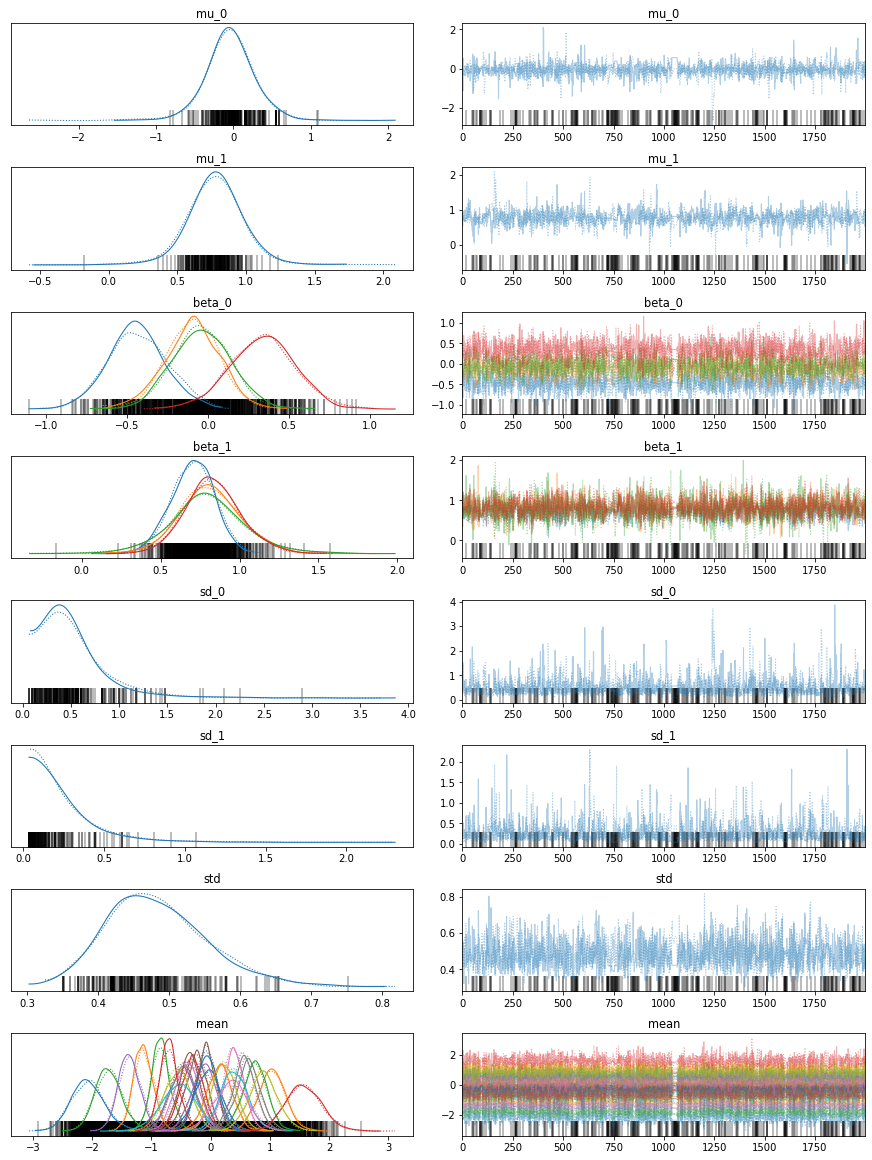

In [127]:
with model_Hierarchical:
    trace_Hierarchical = pm.sample(2000,tune=5000, cores=2)
    pm.traceplot(trace_Hierarchical)

* The low number of effective samples is usually an indication of strong autocorrelation in the chain. Can be observed from the traceplot.
* warning threshold in PyMC3 currently seems a bit too sensitive 
* As in Stan they only output low number of effective samples warning when < .01%

### Out of sample forecast

In [128]:
predictors_1_out_of_sample = np.asarray(test_X['panel_sales'])
quarter_index_out_of_sample = np.asarray(test_X['Qtr'])

outcomes_out_of_sample = test['y'].values
with model_Hierarchical:
    # update values of predictors:
    pm.set_data({"pred_1": predictors_1_out_of_sample})
    pm.set_data({"quarter_index_shared": quarter_index_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    pp_trace = pm.sample_posterior_predictive(trace_Hierarchical,samples=2000)

/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


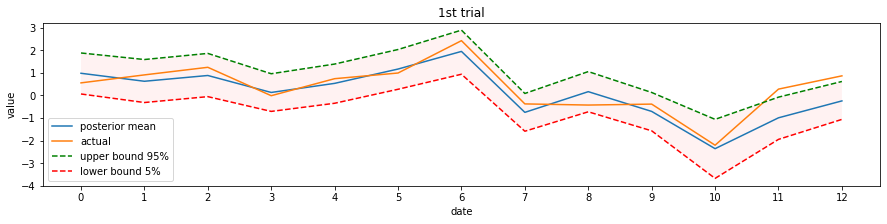

Mean Absolute Percetage Error: 0.45 %


In [129]:
obs_simulations = pp_trace['obs']
obs_simulations_reshape = obs_simulations.T
upper_bound = np.quantile(obs_simulations_reshape, 0.95, axis=1)
lower_bound = np.quantile(obs_simulations_reshape, 0.05, axis=1)
mean = pp_trace['obs'].mean(axis=0)

fig, ax = plt.subplots(figsize=(15,3))
ax.set_title ('1st trial')
ax.plot(mean,label='posterior mean')
ax.plot(test_Y,label='actual')
ax.plot(upper_bound,label='upper bound 95%',color='green',linestyle='--')
ax.plot(lower_bound,label='lower bound 5%',color='red',linestyle='--')

ax.set_xlabel('date')
ax.fill_between(np.arange(len(test)), lower_bound, upper_bound,facecolor='red', alpha=0.05)
ax.set_ylabel('value')
ax.set_xticks(np.arange(len(test)))
ax.legend()
plt.show()

print('Mean Absolute Percetage Error: {} %'.format(mape(test_Y,mean).round(2)))

* With hierarchical model,we are able to bring down the MAPE slightly and we can see overall the model performs well on out of sample predictions.
* However, unlike Model_add_regressor, its uncertainty bound can not capture the most recent month sale.
* Overall it is the best models we have tried so far.
